# Practica 2 - Natural Language processing

## Librerías

In [3]:
# Librerías estándar y de utilidades
import os
import re
import numpy as np
import pandas as pd
from collections import Counter

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# NLP y tokenización
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams, pad_sequences

# Modelado con TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Embedding, Dot, Reshape, Dense,
    Bidirectional, LSTM, Dropout,
    GlobalAveragePooling1D
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    TensorBoard, EarlyStopping,
    ReduceLROnPlateau, ModelCheckpoint
)

# Métricas y particionado
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics.pairwise import cosine_similarity


## Funciones

## Descarga y proceso de datos

### Carga de datos

In [4]:
# Directorio de datos (asume ./data)
data_dir   = os.path.join(os.getcwd(), 'data')
train_path = os.path.join(data_dir, 'train.csv')
test_path  = os.path.join(data_dir, 'test.csv')

# Función de carga con detección de encoding
def load_csv(path):
    for enc in ('utf-8', 'latin1', 'iso-8859-1', 'cp1252'):
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"Cargado '{os.path.basename(path)}' con encoding {enc}")
            return df, enc
        except UnicodeDecodeError:
            pass
    raise UnicodeDecodeError(f"No se pudo decodificar {os.path.basename(path)}")

# Cargar ambos ficheros usando la misma codificación
train_df, encoding = load_csv(train_path)
test_df, _         = load_csv(test_path)

# Verificación de shapes
print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)



Cargado 'train.csv' con encoding latin1
Cargado 'test.csv' con encoding latin1
Train shape: (27481, 10)
Test  shape: (4815, 9)


### Exploración y limpieza de datos

In [5]:
# 1. Combinar train y test
data_df = pd.concat([train_df, test_df], ignore_index=True)

# 2. Mostrar número de filas, columnas y primeras filas
print(f"Total de filas: {data_df.shape[0]}, columnas: {data_df.shape[1]}")
display(data_df.head())

# 3. Extraer texto, tokenizar y contar frecuencias
text_series = data_df['text'].dropna().str.lower()
tokens = re.findall(r'\b\w+\b', ' '.join(text_series))
word_counts = Counter(tokens)

print(f"Total de muestras: {data_df.shape[0]}")
print(f"Palabras únicas encontradas: {len(word_counts)}")
print("Top 10 palabras más frecuentes:", word_counts.most_common(10))

# 4. Definir hiperparámetros
BUFFER_SIZE = 32768
BATCH_SIZE  = 128
VOCAB_SIZE  = 8192

print(f"BUFFER_SIZE = {BUFFER_SIZE}")
print(f"BATCH_SIZE  = {BATCH_SIZE}")
print(f"VOCAB_SIZE  = {VOCAB_SIZE}")


Total de filas: 32296, columnas: 10


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


Total de muestras: 32296
Palabras únicas encontradas: 28490
Top 10 palabras más frecuentes: [('i', 18870), ('to', 11249), ('the', 10200), ('a', 7609), ('my', 6264), ('it', 6123), ('you', 6040), ('and', 5827), ('is', 4490), ('in', 4279)]
BUFFER_SIZE = 32768
BATCH_SIZE  = 128
VOCAB_SIZE  = 8192


### Limpieza de datos:

### Preparación de datos

#### Creación del corpus

In [6]:
# 1. Construir conjunto de las VOCAB_SIZE palabras más frecuentes
top_words = {w for w, _ in word_counts.most_common(VOCAB_SIZE)}

# 2. Filtrar y limpiar cada texto
texts = data_df['text'].dropna().str.lower()
corpus_filtered = (
    texts
    .str.findall(r'\b\w+\b')                             # tokenizar
    .apply(lambda toks: ' '.join(t for t in toks if t in top_words))
    .tolist()
)

# 3. Tokenizar el corpus filtrado y generar secuencias
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(corpus_filtered)
sequences = tokenizer.texts_to_sequences(corpus_filtered)

# 4. Diccionarios de mapeo e tamaño real de vocabulario
word2idx   = tokenizer.word_index
idx2word   = {i: w for w, i in word2idx.items()}
vocab_size = min(len(word2idx) + 1, VOCAB_SIZE)

# 5. Verificación rápida
print("Primeros 5 textos filtrados:", corpus_filtered[:5])
print("Primeras 5 secuencias:", sequences[:5])
print("Tamaño de vocabulario efectivo:", vocab_size)



Primeros 5 textos filtrados: ['i d have responded if i were going', 'sooo sad i will miss you here in san diego', 'my boss is me', 'what interview leave me alone', 'sons of why couldn t they put them on the releases we already bought']
Primeras 5 secuencias: [[1, 163, 19, 7648, 71, 1, 151, 49], [421, 117, 1, 63, 94, 7, 91, 10, 1447, 2230], [5, 1410, 9, 16], [51, 1193, 350, 16, 495], [4254, 13, 118, 472, 14, 72, 332, 131, 17, 3, 7649, 50, 210, 569]]
Tamaño de vocabulario efectivo: 8152


#### Generación de los pares de entrenamiento

In [7]:
# Función generadora de pares Skip-Gram positivos sin usar skipgrams()
def generate_skipgram_pairs(sequence, window_size):
    seq_len = tf.shape(sequence)[0]
    positions = tf.range(seq_len)

    def extract_context(i):
        target = sequence[i]
        # Saltar ceros (padding/oov)
        return tf.cond(
            tf.equal(target, 0),
            lambda: tf.data.Dataset.from_tensors((tf.constant(-1, sequence.dtype),
                                                  tf.constant(-1, sequence.dtype))).take(0),
            lambda: _valid_context(i, target)
        )

    def _valid_context(i, target):
        start   = tf.maximum(0, i - window_size)
        end     = tf.minimum(seq_len, i + window_size + 1)
        left    = sequence[start:i]
        right   = sequence[i+1:end]
        context = tf.concat([left, right], axis=0)
        # Filtrar ceros
        nz      = tf.boolean_mask(context, context != 0)
        tgt     = tf.fill([tf.shape(nz)[0]], target)
        return tf.data.Dataset.from_tensor_slices((tgt, nz))

    return tf.data.Dataset.from_tensor_slices(positions).flat_map(extract_context)

# Generación de pairs_by_window igual que antes, pero usando la función anterior
window_sizes = [2, 4]
pairs_by_window = {}
for w in window_sizes:  # [2, 4]
    # Dataset de secuencias variables
    ds    = tf.data.Dataset.from_generator(
                lambda: sequences,
                output_types=tf.int32,
                output_shapes=[None]
            )
    # Flat-map para extraer todos los pares (target, context)
    sg_ds = ds.flat_map(lambda seq: generate_skipgram_pairs(seq, window_size=w))

    # Recoger en lista de tuplas y convertir a arrays
    pairs = list(sg_ds.as_numpy_iterator())
    if pairs:
        t, c      = zip(*pairs)
        targets   = np.array(t, dtype='int32')
        contexts  = np.array(c, dtype='int32')
    else:
        targets   = np.zeros((0,), dtype='int32')
        contexts  = targets.copy()

    pairs_by_window[w] = {'targets': targets, 'contexts': contexts}
    print(f"Window={w}: {len(targets)} pares generados")

# Acceso:
# pairs_by_window[2]['targets'], pairs_by_window[2]['contexts']
# pairs_by_window[4]['targets'], pairs_by_window[4]['contexts']


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


Window=2: 1384586 pares generados
Window=4: 2530442 pares generados


#### Integer-encoding
Un poco de teoría de los dos encoders:

- Integer encoding: X_target y X_context son vectores de enteros donde cada valor es el índice de palabra en el vocabulario. Es lo adecuado cuando se usa una capa Embedding, ya que Keras transforma internamente cada índice en su vector embebido.

- One-hot encoding: cada índice se convierte en un vector binario de longitud vocab_size con un único 1 en la posición correspondiente al índice. Ocupa mucha más memoria y rara vez es necesario si tu primer bloque es Embedding.

In [8]:
datasets = {}
for w, data in pairs_by_window.items():
    t = data['targets']
    c = data['contexts']
    # Entradas como vectores de índices y etiquetas = 1
    datasets[w] = ([t, c], np.ones_like(t, dtype='int32'))
    # Resumen rápido
    print(f"Window={w}: n_pairs={t.shape[0]}, shapes=({t.shape}, {c.shape})")

# Ahora podemos acceder con:
# X_train, y_train = datasets[2]
# X_train, y_train = datasets[4]


Window=2: n_pairs=1384586, shapes=((1384586,), (1384586,))
Window=4: n_pairs=2530442, shapes=((2530442,), (2530442,))


## Arquitectura y ejecucción

### Arquitectura

In [9]:
# CELDA 1: Definición de la arquitectura Skip-Gram con capa Embedding compartida
def build_skipgram_model(vocab_size,
                         embedding_dim,
                         learning_rate=0.025,
                         beta_1=0.9,
                         beta_2=0.999):
    """
    Crea un modelo Skip-Gram que:
     - Recibe dos inputs escalares (target y context).
     - Usa una capa Embedding compartida de tamaño (vocab_size × embedding_dim).
     - Calcula dot-product y pasa por sigmoide.
     - Se compila con binary_crossentropy y Adam.
    """
    # Entradas de índices
    target_input  = Input(shape=(), dtype='int32', name='target_idx')
    context_input = Input(shape=(), dtype='int32', name='context_idx')

    # Capa Embedding compartida
    embed = Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      name='shared_embedding',
                      embeddings_initializer='glorot_uniform',
                      trainable=True)

    # Vectores embebidos
    target_vec  = Reshape((embedding_dim,))(embed(target_input))
    context_vec = Reshape((embedding_dim,))(embed(context_input))

    # Similaridad por producto escalar
    dot_prod = Dot(axes=1)([target_vec, context_vec])

    # Salida sigmoide
    output = Reshape((1,))(dot_prod)
    output = tf.keras.activations.sigmoid(output)

    # Definir y compilar modelo
    model = Model([target_input, context_input], output,
                  name=f"skipgram_{embedding_dim}")
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2),
        metrics=['accuracy']
    )
    return model

### Entrenamiento

In [10]:
# --------------------------------------------------------------
# Entrenamiento de los 6 modelos Skip-Gram (3 dims × 2 ventanas)
# --------------------------------------------------------------
EMBED_DIMS   = [45, 312, 752]
WINDOW_SIZES = [2, 4]
EPOCHS       = 6
BATCH_SIZE   = 256

skipgram_models    = {}
skipgram_histories = {}

for w in WINDOW_SIZES:
    # datasets[w] == ([targets, contexts], y_train)
    (X_t, X_c), y_train = datasets[w]

    for ed in EMBED_DIMS:
        print(f"\nEntrenando Skip-Gram: window={w}, emb_dim={ed}")

        # 1) Construir el modelo
        model = build_skipgram_model(
            vocab_size=vocab_size,
            embedding_dim=ed,
            learning_rate=0.025
        )

        # 2) Entrenar con inputs dispersos
        history = model.fit(
            x=[X_t, X_c],
            y=y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1
        )

        # 3) Guardar modelo e historial
        skipgram_models[(w, ed)]    = model
        skipgram_histories[(w, ed)] = history

# Ahora puedes acceder a:
# - skipgram_models[(w, ed)]
# - skipgram_histories[(w, ed)].history['loss']



Entrenando Skip-Gram: window=2, emb_dim=45
Epoch 1/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9840 - loss: 0.0303
Epoch 2/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 1.0000 - loss: 3.2504e-06
Epoch 3/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 1.0000 - loss: 3.1197e-07
Epoch 4/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 8.6561e-08
Epoch 5/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 4.6046e-08
Epoch 6/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 3.0964e-08

Entrenando Skip-Gram: window=2, emb_dim=312
Epoch 1/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9847 - loss: 0.0245
Epoch 2/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 4.5875e-06
Epoch 3/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 1.0000 - loss: 1.0290e-07
Epoch 4/6
5409/5409 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 3.8900e-08

### Entrenamiento

## Resultados

### Variación de la pérdida

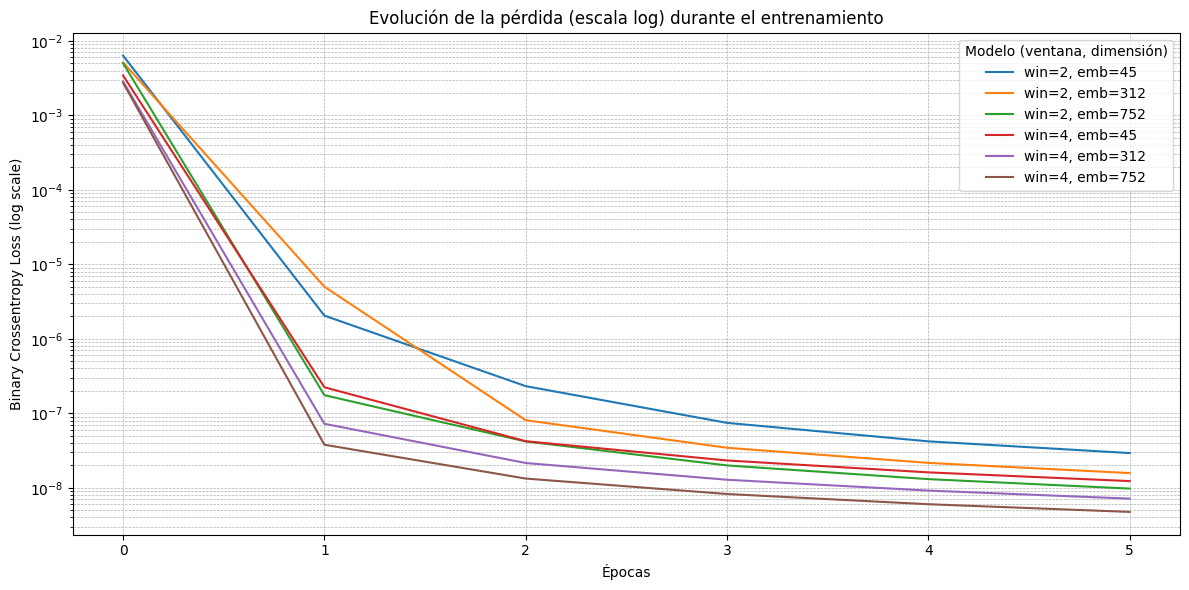

In [11]:
embedding_dims = [45, 312, 752]
window_sizes   = [2, 4]

plt.figure(figsize=(12, 6))

for w in window_sizes:
    for ed in embedding_dims:
        key = (w, ed)
        if key not in skipgram_histories:
            print(f'⚠️ No se encontró historial para ventana={w}, embedding={ed}')
            continue

        loss_values = skipgram_histories[key].history['loss']
        plt.plot(
            loss_values,
            label=f'win={w}, emb={ed}'
        )

plt.yscale('log')
plt.title('Evolución de la pérdida (escala log) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Binary Crossentropy Loss (log scale)')
plt.legend(title='Modelo (ventana, dimensión)')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()


### 10 palabras con más significado

 Listado de las 10 palabras más usadas que efectivamente representan nombres o conceptos clave en tu corpus. Este filtro por POS garantiza que se excluyan términos funcionales y te concentres en las entidades y sustantivos que aportan verdadero “significado” al análisis.


In [12]:
# 1) Definir lista inicial de “palabras baneadas” (stopwords + extras)
banned_words = {
    'a','and','are','be','but','for','have','i','in','is','it','me',
    'my','not','of','on','or','so','that','the','to','we','with',
    'you','rt','http','https','co','nan','com','was','can','this','your'
}

# 2) Iterar sobre word_counts.most_common y filtrar
candidates = []
for word, freq in word_counts.most_common(200):
    if word in banned_words or len(word) < 3:
        continue
    candidates.append((word, freq))
    if len(candidates) >= 10:
        break

# 3) Mostrar listas en formato copy-paste
print("meaningful = [")
for w, f in candidates:
    print(f"    ('{w}', {f}),")
print("]\n")




meaningful = [
    ('just', 2553),
    ('day', 2349),
    ('all', 1852),
    ('good', 1790),
    ('now', 1779),
    ('out', 1698),
    ('get', 1594),
    ('like', 1519),
    ('love', 1304),
    ('too', 1292),
]



### Operaciones con los embeddings

#### Comparación de las 10 palabras seleccionadas

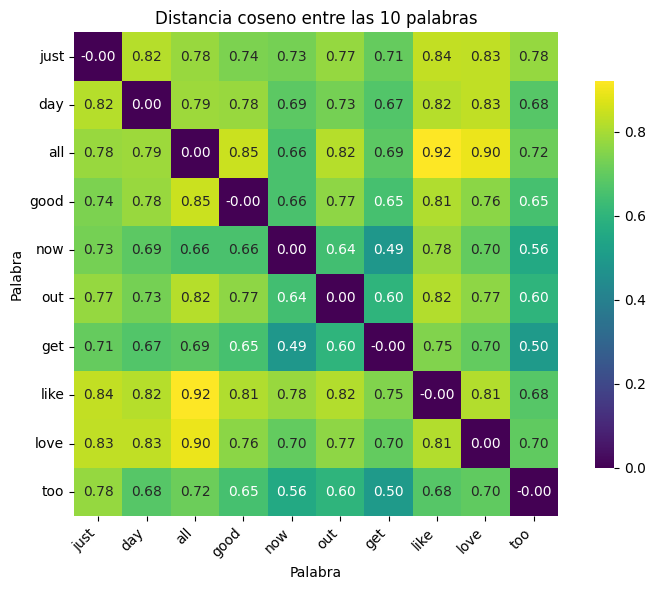

In [13]:
# Extraer las 10 palabras más significativas
words_10 = [w for w, _ in candidates[:10]]

# Obtener matriz de embeddings
emb_matrix = model.get_layer('shared_embedding').get_weights()[0]

# Recoger vectores para esas palabras
vectors_10 = np.vstack([
    emb_matrix[word2idx[w]] if w in word2idx and word2idx[w] < emb_matrix.shape[0]
    else np.zeros(emb_matrix.shape[1])
    for w in words_10
])

# Calcular distancia = 1 – similitud coseno
sim = cosine_similarity(vectors_10)
dist = 1 - sim

# DataFrame de distancias
df_dist = pd.DataFrame(dist, index=words_10, columns=words_10)

# Heatmap sin máscara
plt.figure(figsize=(8, 6))
sns.heatmap(
    df_dist,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Distancia coseno entre las 10 palabras")
plt.xlabel("Palabra")
plt.ylabel("Palabra")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### Mirar 3 grupos de palabras similares

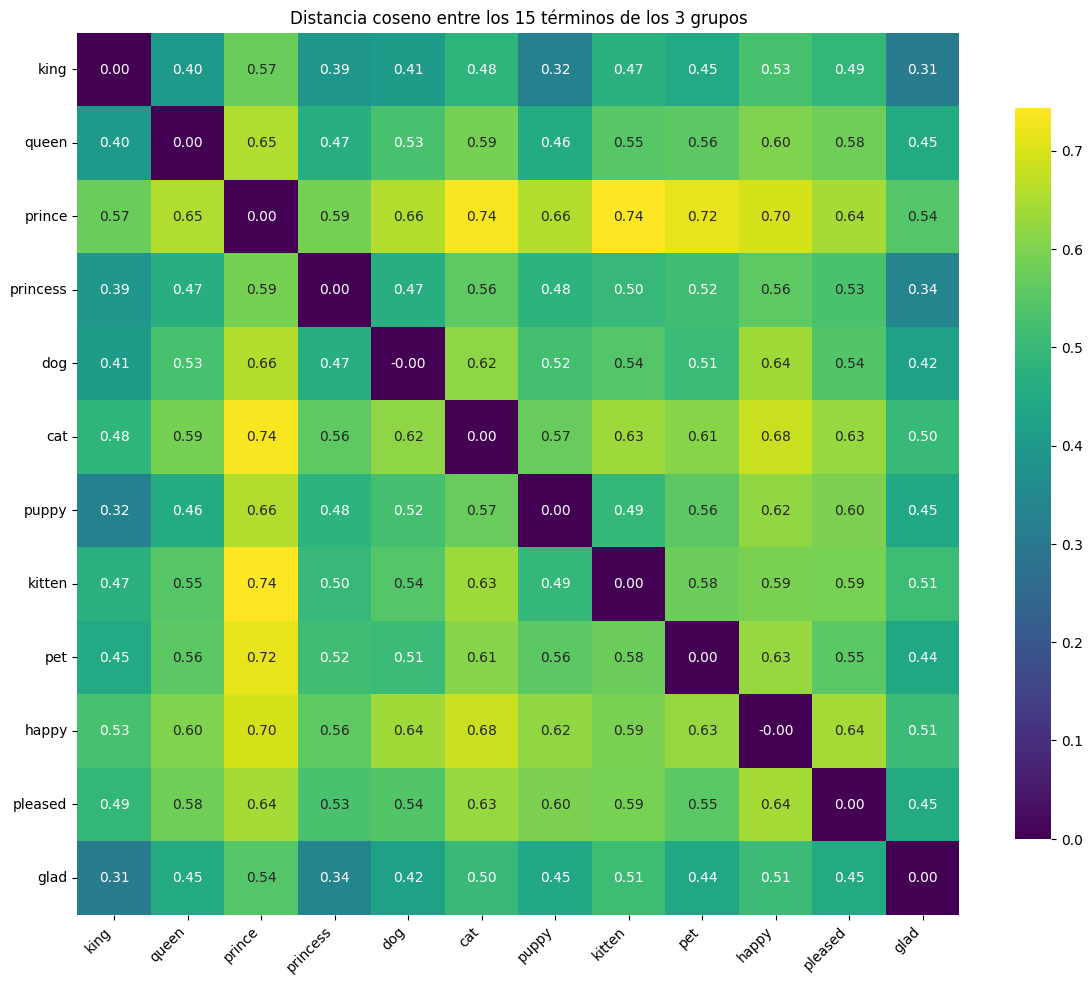

In [14]:
# Define tus tres grupos de palabras directamente
group1 = ["king", "queen", "prince", "princess"]
group2 = ["dog", "cat", "puppy", "kitten", "pet"]
group3 = ["happy", "pleased", "glad"]

# Combina todos los términos en una sola lista
words = group1 + group2 + group3

# Extrae la matriz de embeddings de tu modelo Skip-Gram
emb_matrix = model.get_layer('shared_embedding').get_weights()[0]

# Obtén el vector de embedding para cada palabra
vectors = []
for w in words:
    idx = word2idx.get(w)
    if idx is not None and idx < emb_matrix.shape[0]:
        vectors.append(emb_matrix[idx])
    else:
        vectors.append(np.zeros(emb_matrix.shape[1]))

vectors = np.vstack(vectors)

# Calcula la distancia coseno = 1 – similitud coseno
dist_matrix = 1 - cosine_similarity(vectors)

# Dibuja un único heatmap con las 15 palabras
plt.figure(figsize=(12, 10))
sns.heatmap(
    dist_matrix,
    xticklabels=words,
    yticklabels=words,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("Distancia coseno entre los 15 términos de los 3 grupos")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 3ra Fase - Identificar la intención de las frases

### Seleccionar 2 representaciones de embeddings

Para modelo 1: ventana=2, emb_dim=312

Para modelo 2: ventana=4, emb_dim=752

In [19]:
# -----------------------------------------------------------------
#  Recuperar directamente los modelos Skip-Gram de los objetos History
#  Keras guarda en history.model la instancia del modelo entrenado.
# -----------------------------------------------------------------
model_w2_312 = skipgram_histories[(2, 312)].model
model_w4_752 = skipgram_histories[(4, 752)].model

# -----------------------------------------------------------------
#  Extraer las matrices de pesos de la capa Embedding compartida
# -----------------------------------------------------------------
emb_matrix_2_312 = model_w2_312.get_layer('shared_embedding') \
                                .get_weights()[0]   # (vocab_size, 312)
emb_matrix_4_752 = model_w4_752.get_layer('shared_embedding') \
                                .get_weights()[0]   # (vocab_size, 752)

# -----------------------------------------------------------------
#  Verificar shapes
# -----------------------------------------------------------------
print("Embedding matrix (win=2, dim=312):", emb_matrix_2_312.shape)
print("Embedding matrix (win=4, dim=752):", emb_matrix_4_752.shape)

Embedding matrix (win=2, dim=312): (8152, 312)
Embedding matrix (win=4, dim=752): (8152, 752)


### Preparar los datos de clasificación

Partir de data_df combinado con la columna text y la etiqueta sentiment.

Mapear sentiment → entero (e.g. {negative:0, neutral:1, positive:2}).

Dividir en train/test manteniendo proporción original (o usar los CSV separados).

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

#  Mapear sentiment a enteros
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data_df['sentiment_label'] = data_df['sentiment'].map(sentiment_mapping)  # [1]

#  Eliminar filas con valores nulos en 'text' o en la nueva etiqueta
data_df_clean = data_df.dropna(subset=['text', 'sentiment_label'])

#  Preparar X (texto) y y (etiqueta)
X = data_df_clean['text'].astype(str)
y = data_df_clean['sentiment_label'].astype(int)

#  División estratificada train/test (20% test, semilla fija)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)  # [1]

#  Mostrar tamaños resultantes
print(f"Train: {len(X_train)} muestras")
print(f"Test : {len(X_test)} muestras")

Train: 24811 muestras
Test : 6203 muestras


### Tokenización y padding

In [21]:
# Parámetros
VOCAB_SIZE = 8192    # tal como definimos antes
MAX_LEN    = 50      # longitud fija para todas las secuencias

# Crear y ajustar el Tokenizer solo con el corpus de entrenamiento
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convertir textos a secuencias de enteros
train_seqs = tokenizer.texts_to_sequences(X_train)
test_seqs  = tokenizer.texts_to_sequences(X_test)

# Aplicar padding/truncating a longitud MAX_LEN
X_train_pad = pad_sequences(
    train_seqs,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)
X_test_pad = pad_sequences(
    test_seqs,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)

# Mostrar shapes resultantes
print("X_train_pad shape:", X_train_pad.shape)  # (n_train, MAX_LEN)
print("X_test_pad  shape:", X_test_pad.shape)   # (n_test,  MAX_LEN)
print("y_train shape:", y_train.shape)          # (n_train,)
print("y_test  shape:", y_test.shape)           # (n_test,)

# Ahora X_train_pad, X_test_pad, y_train y y_test están listos para el modelo RNN


X_train_pad shape: (24811, 50)
X_test_pad  shape: (6203, 50)
y_train shape: (24811,)
y_test  shape: (6203,)


### Diseño de la arquitectura recurrente mas entrenamiento

In [29]:
# --------------------------------------------------------------
# Arquitectura RNN afinada (sin silenciar warnings)
# --------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_rnn_classifier_tuned(embedding_matrix,
                               max_len,
                               lstm_units=64,
                               dense_units=32,
                               dropout_rate=0.2,
                               trainable_emb=True):
    vocab_size, emb_dim = embedding_matrix.shape

    inp = Input(shape=(max_len,), dtype='int32')
    x = Embedding(input_dim=vocab_size,
                  output_dim=emb_dim,
                  weights=[embedding_matrix],
                  trainable=trainable_emb)(inp)
    x = Bidirectional(LSTM(lstm_units,
                           dropout=dropout_rate,
                           recurrent_dropout=dropout_rate))(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(3, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(5e-4),
        metrics=['accuracy']
    )
    return model

# Instanciamos solo los dos modelos que luego compararemos:
model_rnn_w2_312 = build_rnn_classifier_tuned(emb_matrix_2_312, MAX_LEN)
model_rnn_w4_752 = build_rnn_classifier_tuned(emb_matrix_4_752, MAX_LEN)
rnn_models = {(2, 312): model_rnn_w2_312, (4, 752): model_rnn_w4_752}

# --------------------------------------------------------------
# Entrenamiento y guardado de los dos mejores modelos
# --------------------------------------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Asumiendo definidos:
#  - model_rnn_w2_312, model_rnn_w4_752
#  - X_train_pad, y_train
#  - Los modelos en un dict:
rnn_models = {
    (2, 312): model_rnn_w2_312,
    (4, 752): model_rnn_w4_752
}

histories_rnn = {}

for (w, ed), model in rnn_models.items():
    # Guardar solo el mejor modelo según val_accuracy,
    # usando extensión .keras para que Keras deduzca el formato.
    ckpt = ModelCheckpoint(
        filepath = f"best_rnn_w{w}_e{ed}.keras",
        monitor = 'val_accuracy',
        mode    = 'max',
        save_best_only = True,
        verbose = 1
    )

    # Reducir LR si la pérdida de validación deja de mejorar
    reduce_lr = ReduceLROnPlateau(
        monitor = 'val_loss',
        factor  = 0.2,
        patience= 1,
        min_lr  = 1e-5,
        mode    = 'min',
        verbose = 1
    )

    print(f"\nEntrenando RNN window={w}, emb_dim={ed}")
    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.10,
        epochs=12,
        batch_size=64,
        callbacks=[ckpt, reduce_lr],
        verbose=1
    )

    histories_rnn[(w, ed)] = history

# Al terminar tendrás dos archivos:
#   best_rnn_w2_e312.keras
#   best_rnn_w4_e752.keras
# y en `histories_rnn` los historiales de cada entrenamiento.





Entrenando RNN window=2, emb_dim=312
Epoch 1/12
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4163 - loss: 1.0782
Epoch 1: val_accuracy improved from -inf to 0.52901, saving model to best_rnn_w2_e312.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 115s 310ms/step - accuracy: 0.4164 - loss: 1.0781 - val_accuracy: 0.5290 - val_loss: 0.9549 - learning_rate: 5.0000e-04
Epoch 2/12
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5325 - loss: 0.9427
Epoch 2: val_accuracy improved from 0.52901 to 0.66519, saving model to best_rnn_w2_e312.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 147s 326ms/step - accuracy: 0.5326 - loss: 0.9425 - val_accuracy: 0.6652 - val_loss: 0.7621 - learning_rate: 5.0000e-04
Epoch 3/12
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6609 - loss: 0.7627
Epoch 3: val_accuracy improved from 0.66519 to 0.70991, saving model to best_rnn_w2_e312.keras
349/349 ━━━━━━━━━━━━━━━━━━━━ 137s 312ms/step - accuracy: 0.6609 - loss: 0.7627 - val_accuracy: 0.7099 - val_loss: 0.68

### Evaluación y matriz de confusión

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Asumimos definidos:
#  - rnn_models: dict {(2,312): model_rnn_w2_312, (4,752): model_rnn_w4_752}
#  - X_train_pad, X_test_pad, y_train, y_test
#  - BATCH_SIZE

label_names = ['negative', 'neutral', 'positive']

for (w, ed), rnn_model in rnn_models.items():
    print(f"\n=== Evaluación RNN (ventana={w}, emb_dim={ed}) ===")

    # 1) Predicciones sobre el conjunto de entrenamiento
    y_pred_train_proba = rnn_model.predict(
        X_train_pad, batch_size=BATCH_SIZE, verbose=0
    )
    y_pred_train = np.argmax(y_pred_train_proba, axis=1)

    # 2) Matriz de confusión y reporte sobre train
    cm_train = confusion_matrix(y_train, y_pred_train)
    print("\n-- Train set --")
    print("Confusion Matrix:")
    print(cm_train)
    print("\nClassification Report:")
    print(classification_report(
        y_train, y_pred_train, target_names=label_names
    ))

    # 3) Predicciones sobre el conjunto de test
    y_pred_test_proba = rnn_model.predict(
        X_test_pad, batch_size=BATCH_SIZE, verbose=0
    )
    y_pred_test = np.argmax(y_pred_test_proba, axis=1)

    # 4) Matriz de confusión y reporte sobre test
    cm_test = confusion_matrix(y_test, y_pred_test)
    print("-- Test set --")
    print("Confusion Matrix:")
    print(cm_test)
    print("\nClassification Report:")
    print(classification_report(
        y_test, y_pred_test, target_names=label_names
    ))



=== Evaluación RNN (ventana=2, emb_dim=312) ===

-- Train set --
Confusion Matrix:
[[5696 1182  148]
 [1018 8262  757]
 [ 172  936 6640]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.81      0.82      7026
     neutral       0.80      0.82      0.81     10037
    positive       0.88      0.86      0.87      7748

    accuracy                           0.83     24811
   macro avg       0.83      0.83      0.83     24811
weighted avg       0.83      0.83      0.83     24811

-- Test set --
Confusion Matrix:
[[1228  460   68]
 [ 436 1744  330]
 [  53  374 1510]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.70      0.71      1756
     neutral       0.68      0.69      0.69      2510
    positive       0.79      0.78      0.79      1937

    accuracy                           0.72      6203
   macro avg       0.73      0.72      0.73      6203
weighted avg      

In [ ]:
import time

print("El código está en ejecución. Para detenerlo, usa el botón de detener en Colab (el cuadrado).")

while True:
    time.sleep(60)  # Espera 60 segundos en cada iteración para no consumir recursos innecesariamente

El código está en ejecución. Para detenerlo, usa el botón de detener en Colab (el cuadrado).
